<h2><b>Influence of technical indicators on the forecasting quality of machine learning models for the prediction of share prices</b></h2>
<b>Author:</b> Benedikt Grimus</br>
<b>E-Mail:</b> benedikt.grimus@gmail.com

<h2>LSTM Model</h2>

<h3>Importing the required packages</h3>

In [31]:
# manipulate data and mathematical operations
import numpy as np
import pandas as pd
# save and read files
import os
#visualisation
import matplotlib.pyplot as plt
# getting historical stock data
import yfinance
#work with times
import datetime
import time
# create permutations
import itertools
# scale features and split data into training and testing set
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# LSTM model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
#error metric
from sklearn.metrics import mean_absolute_error
# kpss test
from statsmodels.tsa.stattools import kpss
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

<h3>Download historical stock data</h3>

In [32]:
def get_historical_stock_data(tickers: list[str], start_date: datetime.datetime, end_date:datetime.datetime) -> list[pd.DataFrame]:
    """
    This function retrieves historical stock data for a given list of tickers within a specified date range.
    It uses the yfinance library to fetch the data and drops unnecessary columns.
    
    Parameters:
    tickers (list[str]): A list of stock ticker symbols for which historical data needs to be fetched.
    start_date (datetime.datetime): The start date of the historical data period.
    end_date (datetime.datetime): The end date of the historical data period.
    
    Returns:
    list[pd.DataFrame]: A list of pandas DataFrames, each containing historical stock data for a single ticker. 
    A single data frame contains two columns, the open and the close price and uses the date as the index.
    If an error occurs while fetching data for a ticker, it is removed from the list and a message is printed.
    """
    hist_data_all_stocks = []
    for ticker in tickers:
        try:
            hist_data_all_stocks.append(yfinance.Ticker(ticker=ticker).history(start=start_date, end=end_date))
            hist_data_all_stocks[-1] = hist_data_all_stocks[-1].drop(["High","Low","Volume","Dividends","Stock Splits"], axis=1)
        except:
            tickers.remove(ticker)
            print(f"Error with ticker {ticker}! REMOVED it!")
    return hist_data_all_stocks

In [33]:
# Test | is used for development purposes
tickers = ["AAPL"]
# S&P 500
# tickers = ["AAPL","MSFT","AMZN","NVDA","BRK-B","GOOGL","TSLA","XOM","UNH","META","JNJ","JPM","V","PG","HD","MA","CVX","ABBV","MRK","LLY","AVGO","PEP","KO","PFE","TMO","COST","BAC","CSCO","WMT","MCD"]
# DAX
# tickers = ["SAP.DE","SIE.DE","ALV.DE","DTE.DE","AIR.DE","BAYN.SG","MBG.DE","BAS.DE","MUV2.MI","IFX.DE","DPW.DE","DB1.DE","VOW.DE","BMW.DE","RWE.DE","MRK.DE","DBK.DE","ADS.DE","EOAN.DE","VNA.DE","SHL.DE","DTG.DE","CBK.DE","SY1.DE","PAH3.DE","MTX.DE","HNR1.DE","FRE.DE","BEI.DE","HEN3.DE"]
start_date = datetime.datetime(2020,1,1)
end_date = datetime.datetime(2023,1,1)

hist_data_all_stocks = get_historical_stock_data(tickers=tickers, start_date=start_date, end_date=end_date)

<h3>Calculate technical indicators</h3>

In [34]:
def calc_technical_indicators(hist_data_all_stocks: list[pd.DataFrame], volatility_window: int = 20, momentum_window: int = 20, ma_window: int = 20) -> list[pd.DataFrame]:
    """
    This function calculates technical indicators for a list of historical stock data DataFrames.
    It calculates Volatility, Relative Strength Index (RSI), Moving Average Convergence Divergence (MACD), and Momentum.
    
    Parameters:
    hist_data_all_stocks (list[pd.DataFrame]): A list of pandas DataFrames, each containing historical stock data for a single ticker.
    volatility_window (int): The window size for calculating volatility. Default is 20.
    momentum_window (int): The window size for calculating momentum. Default is 20.
    ma_window (int): The window size for calculating moving average. Default is 20.
    
    Returns:
    list[pd.DataFrame]: A list of pandas DataFrames, each containing the original historical stock data with added technical indicators.
    """
    for i in range(len(hist_data_all_stocks)):
        #Volatility
        hist_data_all_stocks[i][f"Vol_{volatility_window}"] = hist_data_all_stocks[i]['Open'].rolling(volatility_window).std()
        #RSI
        delta = hist_data_all_stocks[i]['Open'].diff()
        up = delta.clip(lower=0)
        down = -1*delta.clip(upper=0)
        ema_up = up.ewm(com=14, adjust=False).mean()
        ema_down = down.ewm(com=14, adjust=False).mean()
        rs = ema_up/ema_down
        hist_data_all_stocks[i]['RSI'] = (100 - (100/(1 + rs)))
        #MACD
        hist_data_all_stocks[i]['MACD'] = hist_data_all_stocks[i]['Open'].ewm(span=12).mean() - hist_data_all_stocks[i]['Open'].ewm(span=26).mean()
        #Momentum
        hist_data_all_stocks[i][f'Mom_{momentum_window}'] = hist_data_all_stocks[i]['Open'] - hist_data_all_stocks[i]['Open'].shift(momentum_window)
        #Moving Average
        hist_data_all_stocks[i][f'MA_{ma_window}'] = hist_data_all_stocks[i]['Open'].rolling(ma_window).mean()
        #Drop na values
        hist_data_all_stocks[i] = hist_data_all_stocks[i].dropna()
        #Rearrange the order of the columns so that the target is at the end
        hist_data_all_stocks[i].insert(len(hist_data_all_stocks[i].columns) - 1, "Close", hist_data_all_stocks[i].pop('Close'))
    return hist_data_all_stocks

In [35]:
hist_data_all_stocks = calc_technical_indicators(hist_data_all_stocks=hist_data_all_stocks)

<h3>Establish stationarity using the first difference method</h3>

In [36]:
#create a copy of all data frames because it is needed to reverse the first difference method which is used to establish stationarity
hist_data_all_stocks_non_stationary = []
for i in range(len(hist_data_all_stocks)):
    hist_data_all_stocks_non_stationary.append(hist_data_all_stocks[i].copy())

In [37]:
def make_stationary(hist_data_all_stocks: list[pd.DataFrame]) -> list[pd.DataFrame]:
    """
    This function makes the time series data stationary by applying the first difference method.
    The first difference method calculates the difference between consecutive observations.
    This helps to remove trends and seasonality from the data, making it easier to analyze and model.

    Parameters:
    hist_data_all_stocks (list[pd.DataFrame]): A list of pandas DataFrames, each containing historical stock data for a single ticker.
        The data should be indexed by date and contain at least one column representing the stock price.

    Returns:
    list[pd.DataFrame]: A list of pandas DataFrames, each containing the stationary historical stock data for a single ticker.
        The first difference method has been applied to remove trends and seasonality.
    """
    for i in range(len(hist_data_all_stocks)):
        hist_data_all_stocks[i] = hist_data_all_stocks[i].diff().dropna()
    return hist_data_all_stocks

In [38]:
hist_data_all_stocks_stationary = make_stationary(hist_data_all_stocks)

<h3>Check for stationarity using the KPSS test</h3>

In [39]:
def test_stationary(data: pd.Series, significance: float = 0.05):
    """
    This function tests the stationarity of a given time series data using the KPSS test.
    The KPSS test is a statistical test for checking if a time series is stationary around a deterministic trend.

    Parameters:
    data (pd.Series): The time series data to be tested for stationarity. It should be indexed by date.
    significance (float): The significance level for the KPSS test. Default is 0.05.

    Returns:
    bool: True if the time series is stationary (p-value >= significance), False otherwise.
    """
    statistic, p_value, n_lags, critical_values = kpss(data)
    for key, value in critical_values.items():
        if p_value < significance:
            return False
        else:
            return True

In [40]:
#Loop through all companies and technical indicators
for i in range(len(hist_data_all_stocks_stationary)):
    for j in range(len(hist_data_all_stocks_stationary[i].columns)):
        if test_stationary(hist_data_all_stocks_stationary[i][hist_data_all_stocks_stationary[i].columns[j]]) != True:
            print(f"{tickers[i]} {hist_data_all_stocks_stationary[i].columns[j]} not stationary")

<h3>Create all possible feature combinations</h3>

In [41]:
# Creates all possible feature combinations and adds the Close column as the target column to the data frame
feature_combinations = []
n_features = hist_data_all_stocks_stationary[0].columns[0:len(hist_data_all_stocks_stationary[0].columns) - 1].tolist()
for i in range(len(hist_data_all_stocks_stationary[0].columns) + 1):
    for subset in itertools.combinations(n_features, i):
        if(len(subset) != 0):
            feature_combinations.append(list(subset))
            feature_combinations[-1].append("Close")

In [42]:
# Assing the lists with the data frames to a single list 
# A list containing different lists which contain data frames each with a different subset of features and the target variable
hist_data_all_stocks_feature_combinations = []
for i in range(len(hist_data_all_stocks)):
    all_feature_combinations_single_stock = []
    for j in range(len(feature_combinations)):
        all_feature_combinations_single_stock.append(hist_data_all_stocks_stationary[i][feature_combinations[j]])
    hist_data_all_stocks_feature_combinations.append(all_feature_combinations_single_stock)

<h3>Scale between 0 and 1 using MinMaScaler</h3>

In [43]:
def scale_values(hist_data_all_stocks_feature_combinations: list[pd.DataFrame]) -> tuple[list[np.ndarray], list[np.ndarray], list[MinMaxScaler], list[MinMaxScaler]]:
    """
    This function scales the features and target values of a list of data frames using MinMaxScaler.
    The scalers are returned to be able to scale the predicted values back.

    Parameters:
    hist_data_all_stocks_feature_combinations (list[pd.DataFrame]): A list of data frames, each containing a different combination of features and the target variable.
        The data frames should have columns representing the features and a 'Close' column representing the target variable.

    Returns:
    tuple[list[np.ndarray], list[np.ndarray], list[MinMaxScaler], list[MinMaxScaler]]: A tuple containing four lists:
        - scaled_features_all_stocks: A list of lists, where each inner list contains the scaled features of the corresponding data frame in the input list.
        - scaled_target_all_stocks: A list of lists, where each inner list contains the scaled target values of the corresponding data frame in the input list.
        - feature_scaler_all_stocks: A list of MinMaxScaler objects, each corresponding to the scaler used to scale the features of the corresponding data frame.
        - target_scaler_all_stocks: A list of MinMaxScaler objects, each corresponding to the scaler used to scale the target values of the corresponding data frame.
    """
    #The scalers are returned to be able to scale the predicted values back
    feature_scaler_all_stocks = []
    scaled_features_all_stocks = []
    target_scaler_all_stocks = []
    scaled_target_all_stocks = []
    for i in range(len(hist_data_all_stocks_feature_combinations)):
        feature_scaler_single_stock = []
        scaled_features_single_stock = []
        target_scaler_single_stock = []
        scaled_target_single_stock = []
        for j in range(len(hist_data_all_stocks_feature_combinations[i])):
            features = hist_data_all_stocks_feature_combinations[i][j].loc[:,~hist_data_all_stocks_feature_combinations[i][j].columns.isin(['Close'])]
            feature_scaler = MinMaxScaler()
            scaled_features_single_stock.append(feature_scaler.fit_transform(features))
            feature_scaler_single_stock.append(feature_scaler)
            
            target = hist_data_all_stocks_feature_combinations[i][j].loc[:,hist_data_all_stocks_feature_combinations[i][j].columns.isin(['Close'])]
            target_scaler = MinMaxScaler()
            scaled_target_single_stock.append(target_scaler.fit_transform(target))
            target_scaler_single_stock.append(target_scaler)
        
        scaled_features_all_stocks.append(scaled_features_single_stock)
        feature_scaler_all_stocks.append(feature_scaler_single_stock)
        scaled_target_all_stocks.append(scaled_target_single_stock)
        target_scaler_all_stocks.append(target_scaler_single_stock)

    return scaled_features_all_stocks, scaled_target_all_stocks, feature_scaler_all_stocks, target_scaler_all_stocks

In [44]:
scaled_features_all_stocks, scaled_target_all_stocks, feature_scaler_all_stocks, target_scaler_all_stocks = scale_values(hist_data_all_stocks_feature_combinations)

<h3>Split into training and testing set</h3>

In [45]:
def split_data(scaled_features_all_stocks, scaled_target_all_stocks, train_size=0.8) -> list[list, list, list, list]:
    """
    This function splits the scaled features and targets into training and testing sets.
    
    Parameters:
    scaled_features_all_stocks (list): A list containing a list for each examined stock, which contains lists with the scaled features for all different feature combinations.
    scaled_target_all_stocks (list): A list containing a list for each examined stock, which contains lists with the scaled targets for all different feature combinations.
    train_size (float, optional): The proportion of the data to include in the training set. Default is 0.8.
    
    Returns:
    train_test_all_stocks (list): A list containing a list for each stock which contains a list for each feature combination. Each inner list contains four lists: features train, features test, targets train, targets test.
    """
    train_test_all_stocks = []
    for i in range(len(scaled_features_all_stocks)):
        train_test_single_stock = []
        for j in range(len(scaled_features_all_stocks[i])):
            x_train, x_test, y_train, y_test = train_test_split(scaled_features_all_stocks[i][j], scaled_target_all_stocks[i][j], train_size=train_size, shuffle=False)
            train_test_single_stock.append([x_train, x_test, y_train, y_test])
        train_test_all_stocks.append(train_test_single_stock)
    return train_test_all_stocks

In [46]:
train_test_all_stocks = split_data(scaled_features_all_stocks, scaled_target_all_stocks)

<h3>Bring the training and testing dataset into the right format (samples, LSTM_input_vector_size, features)</h3>

In [47]:
def format_dataset(x_values: list, y_values: list, LSTM_input_vector_size: int = 10):
    """
    Format the dataset for LSTM input.

    Parameters:
    x_values (numpy.ndarray): A numpy array containing the timeseries features.
    y_values (numpy.ndarray): A numpy array containing the corresponding target values.
    LSTM_input_vector_size (int, optional): The size of the input vector for the LSTM model. Default is 10.

    Returns:
    dataX (numpy.ndarray): A numpy array containing the input vectors for the LSTM model.
    dataY (numpy.ndarray): A numpy array containing the corresponding target values for the LSTM model.
    """
    dataX, dataY = [], []

    for i in range(LSTM_input_vector_size, len(x_values)):
        #dataX.append(x_values[(i - LSTM_input_vector_size):i, :])
        dataX.append(x_values[(i - LSTM_input_vector_size):i])
        dataY.append(y_values[i])

    return np.array(dataX), np.array(dataY)

In [48]:
input_vector_size: int = 10

for i in range(len(train_test_all_stocks)):
    for j in range(len(train_test_all_stocks[i])):
        train_test_all_stocks[i][j][0], train_test_all_stocks[i][j][2] = format_dataset(train_test_all_stocks[i][j][0], train_test_all_stocks[i][j][2], input_vector_size)
        train_test_all_stocks[i][j][1], train_test_all_stocks[i][j][3] = format_dataset(train_test_all_stocks[i][j][1], train_test_all_stocks[i][j][3], input_vector_size)

In [49]:
print(f"Training Set Shape: X={train_test_all_stocks[i][j][0].shape} Y={train_test_all_stocks[i][j][2].shape}")
print(f"Testing Set Shape: X={train_test_all_stocks[i][j][1].shape} Y={train_test_all_stocks[i][j][3].shape}")

Training Set Shape: X=(578, 10, 6) Y=(578, 1)
Testing Set Shape: X=(137, 10, 6) Y=(137, 1)


<h3>Function for creating a LSTM model</h3>

In [50]:
def create_model(LSTM_input_vector_size: int, n_features: int) -> Sequential:
    """
    This function creates a LSTM model for predicting stock prices.

    Parameters:
    LSTM_input_vector_size (int): The size of the input vector for the LSTM model.
    features (int): The number of features in the input data.

    Returns:
    model (Sequential): A compiled LSTM model for predicting stock prices.
    """
    neurons = n_features * LSTM_input_vector_size
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(LSTM_input_vector_size, n_features)))
    model.add(LSTM(neurons, return_sequences=True))
    model.add(LSTM(neurons, return_sequences=False))
    model.add(Dense(n_features))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

<h3>Function for saving and loading a trained model</h3>

In [51]:
def save_model(model: Sequential, ticker: str, id: int) -> None:
    """
    This function saves a trained LSTM model to a specified file path.

    Parameters:
    model (tensorflow.keras.models.Sequential): The trained LSTM model to be saved.
    ticker (str): The string representing the stock the model was trained on.
    id (int): A number used to differentiate between the feature combination that was used to train the model.

    Returns:
    None
    """
    file_path = "{}{}{}{}{}".format(os.getcwd(), os.sep, "Pretrained_LSTM_Models", os.sep,f"model_{ticker}_{id}.h5")
    model.save(file_path)
    
def load_pretrained_model(ticker: str, id: int):
    """
    This function loads a pre-trained LSTM model from a specified file path.

    Parameters:
    ticker (str): The string representing the stock the model was trained on.
    id (int): A number used to differentiate between the feature combination that was used to train the model.

    Returns:
    model (tensorflow.keras.models.Sequential): The loaded pre-trained LSTM model.
    """
    file_path = "{}{}{}{}{}".format(os.getcwd(), os.sep, "Pretrained_LSTM_Models", os.sep,f"model_{ticker}_{id}.h5")
    model = load_model(file_path)
    return model

<h3>Train the LSTM models</h3>

In [29]:
#Depending of the number of tickers training takes several hours
time_of_training = []
number_of_models = len(tickers) * len(feature_combinations)

epochs = 15
batch_size = 8
#Loop through each stock
for i in range(len(train_test_all_stocks)):
    #Loop through all feature combinations
    for j in range(len(train_test_all_stocks[i])):
        model_start_time = time.time()
        current_model_number = i * len(train_test_all_stocks[i]) + j + 1
        model = create_model(train_test_all_stocks[i][j][0].shape[1], train_test_all_stocks[i][j][0].shape[2])
        model.fit(train_test_all_stocks[i][j][0], train_test_all_stocks[i][j][2], validation_data=(train_test_all_stocks[i][j][1], train_test_all_stocks[i][j][3]), epochs=epochs, batch_size=batch_size ,verbose=0)
        save_model(model, tickers[i], j)
        time_of_training.append(time.time() - model_start_time)
        expected_remaining_time = np.round(np.mean(time_of_training) * (number_of_models - current_model_number) / 60, 2)
        #Print the remaining time
        if(number_of_models >= 10):
            if(current_model_number % int(number_of_models * 0.1) == 0):
                print(f"Create Model: {current_model_number} of {number_of_models}")
                print(f"Expected remaining time: {expected_remaining_time}min or {np.round(expected_remaining_time*60, 0)}s Current Ø time per model: {np.round(np.mean(time_of_training),1)}s")
        else:
            print(f"Create Model: {current_model_number} of {number_of_models}")
            print(f"Expected remaining time: {expected_remaining_time}min or {np.round(expected_remaining_time*60, 0)}s Current Ø time per model: {np.round(np.mean(time_of_training),1)}s")

Create Model: 6 of 63
Expected remaining time: 23.06min or 1384.0s Current Ø time per model: 24.3s
Create Model: 12 of 63
Expected remaining time: 20.89min or 1253.0s Current Ø time per model: 24.6s
Create Model: 18 of 63
Expected remaining time: 18.32min or 1099.0s Current Ø time per model: 24.4s
Create Model: 24 of 63
Expected remaining time: 16.33min or 980.0s Current Ø time per model: 25.1s
Create Model: 30 of 63
Expected remaining time: 14.13min or 848.0s Current Ø time per model: 25.7s
Create Model: 36 of 63
Expected remaining time: 11.66min or 700.0s Current Ø time per model: 25.9s
Create Model: 42 of 63
Expected remaining time: 9.16min or 550.0s Current Ø time per model: 26.2s
Create Model: 48 of 63
Expected remaining time: 6.64min or 398.0s Current Ø time per model: 26.6s
Create Model: 54 of 63
Expected remaining time: 4.04min or 242.0s Current Ø time per model: 26.9s
Create Model: 60 of 63
Expected remaining time: 1.37min or 82.0s Current Ø time per model: 27.4s


<h3>Function for calculating the mean absolute percentage error</h3>

In [52]:
def calc_mape(actual: list, predicted: list) -> float:
    """
    Calculates the Mean Absolute Percentage Error (MAPE) between two sets of values.

    Parameters:
    actual (numpy.ndarray or list): The actual values.
    predicted (numpy.ndarray or list): The predicted values.

    Returns:
    float: The Mean Absolute Percentage Error (MAPE) between the actual and predicted values.
    """
    mape = np.mean(np.abs((np.array(actual) - np.array(predicted)) / np.array(actual))) * 100
    return mape

<h3>Create predictions using the models and calculate MAPE and accuracy</h3>

In [53]:
#boolean to control wheter the predictions and the targets from the test set should be saved (True) to be able to plot the predictions against the target
save_predictions_and_y_test = True

mape = []
pred_rescaled_inversed_difference_all_stocks = []
y_test_rescaled_inversed_difference_all_stocks = []
y_test_direction_accuracy = []
#Loop through all stocks
for i in range(len(train_test_all_stocks)):
    pred_rescaled_inversed_difference_single_stock = []
    y_test_rescaled_inversed_difference_single_stock = []
    #Loop through all feature combinations
    for j in range(len(train_test_all_stocks[i])):
        #Rescale the target variables (Close)
        y_test_rescaled = target_scaler_all_stocks[i][j].inverse_transform(train_test_all_stocks[i][j][3])
        #Load the model and predict
        model = load_pretrained_model(tickers[i], j)
        pred = model.predict(train_test_all_stocks[i][j][1], verbose=0)
        #Rescale the prediction
        pred_rescaled = target_scaler_all_stocks[i][j].inverse_transform(pred)
        pred_rescaled_inversed_difference_single_stock_single_model = []
        y_test_rescaled_inversed_difference_single_stock_single_model = []
        same_direction = 0
        #Calculate the accuracy by looping through the predictions
        for k in range(len(pred_rescaled)):
            if np.sign(pred_rescaled[k]) == np.sign(y_test_rescaled[k]):
                same_direction += 1
                #Reverse the first difference method
            pred_rescaled_inversed_difference_single_stock_single_model.append(hist_data_all_stocks_non_stationary[i]['Close'].iloc[len(hist_data_all_stocks_non_stationary[i]['Close']) - len(pred_rescaled) + k] + pred_rescaled[k])
            y_test_rescaled_inversed_difference_single_stock_single_model.append(hist_data_all_stocks_non_stationary[i]['Close'].iloc[len(hist_data_all_stocks_non_stationary[i]['Close']) - len(pred_rescaled) + k] + y_test_rescaled[k])
        y_test_direction_accuracy.append(same_direction / len(pred_rescaled))
        pred_rescaled_inversed_difference_single_stock.append(pred_rescaled_inversed_difference_single_stock_single_model)
        y_test_rescaled_inversed_difference_single_stock.append(y_test_rescaled_inversed_difference_single_stock)
        #Calculate the MAPE
        mape.append(calc_mape(y_test_rescaled_inversed_difference_single_stock_single_model, pred_rescaled_inversed_difference_single_stock_single_model))
    if save_predictions_and_y_test:
        pred_rescaled_inversed_difference_all_stocks.append(pred_rescaled_inversed_difference_single_stock)
        y_test_rescaled_inversed_difference_all_stocks.append(y_test_rescaled_inversed_difference_single_stock)

<h3>Create the x labels for plotting</h3>

In [54]:
#Create x labels is nothing else than just removing the "Close" column from the feature combinations
x_labels = []
for i in range(len(feature_combinations)):
    string = ""
    for j in range(len(feature_combinations[i])):
        if(feature_combinations[i][j] != "Close"):
            string += feature_combinations[i][j]
            if j != len(feature_combinations[i]) - 2:
                string += " + \n"
    x_labels.append(string)

<h3>Create a data frame containg the accuracy results</h3>

In [55]:
results_df_direction = pd.DataFrame(np.array(y_test_direction_accuracy).reshape(-1,len(x_labels)), columns=[x_labels + " dir. acc." for x_labels in x_labels], index=tickers)
results_df_direction

,Open dir. acc.,Vol_20 dir. acc.,RSI dir. acc.,MACD dir. acc.,Mom_20 dir. acc.,MA_20 dir. acc.,Open + \nVol_20 dir. acc.,Open + \nRSI dir. acc.,Open + \nMACD dir. acc.,Open + \nMom_20 dir. acc.,...,Vol_20 + \nRSI + \nMom_20 + \nMA_20 dir. acc.,Vol_20 + \nMACD + \nMom_20 + \nMA_20 dir. acc.,RSI + \nMACD + \nMom_20 + \nMA_20 dir. acc.,Open + \nVol_20 + \nRSI + \nMACD + \nMom_20 dir. acc.,Open + \nVol_20 + \nRSI + \nMACD + \nMA_20 dir. acc.,Open + \nVol_20 + \nRSI + \nMom_20 + \nMA_20 dir. acc.,Open + \nVol_20 + \nMACD + \nMom_20 + \nMA_20 dir. acc.,Open + \nRSI + \nMACD + \nMom_20 + \nMA_20 dir. acc.,Vol_20 + \nRSI + \nMACD + \nMom_20 + \nMA_20 dir. acc.,Open + \nVol_20 + \nRSI + \nMACD + \nMom_20 + \nMA_20 dir. acc.
AAPL,0.510949,0.474453,0.474453,0.481752,0.49635,0.518248,0.49635,0.481752,0.474453,0.489051,...,0.474453,0.518248,0.532847,0.474453,0.510949,0.518248,0.518248,0.525547,0.532847,0.474453


<h3>Create a data frame containg the MAPE results</h3>

In [56]:
results_df_mae = pd.DataFrame(np.array(mape).reshape(-1,len(x_labels)), columns=x_labels, index=tickers)
results_df_mae

,Open,Vol_20,RSI,MACD,Mom_20,MA_20,Open + \nVol_20,Open + \nRSI,Open + \nMACD,Open + \nMom_20,...,Vol_20 + \nRSI + \nMom_20 + \nMA_20,Vol_20 + \nMACD + \nMom_20 + \nMA_20,RSI + \nMACD + \nMom_20 + \nMA_20,Open + \nVol_20 + \nRSI + \nMACD + \nMom_20,Open + \nVol_20 + \nRSI + \nMACD + \nMA_20,Open + \nVol_20 + \nRSI + \nMom_20 + \nMA_20,Open + \nVol_20 + \nMACD + \nMom_20 + \nMA_20,Open + \nRSI + \nMACD + \nMom_20 + \nMA_20,Vol_20 + \nRSI + \nMACD + \nMom_20 + \nMA_20,Open + \nVol_20 + \nRSI + \nMACD + \nMom_20 + \nMA_20
AAPL,1.703692,1.747248,1.754036,1.733122,1.697673,1.699659,1.70872,1.721277,1.711314,1.711275,...,1.74082,1.696444,1.69306,1.791259,1.706525,1.751895,1.73694,1.692921,1.692591,2.008673


<h3>Merge the data frames and save them as an Excel file</h3>

In [57]:
excel_file_name = 'LSTM_results_test'

results_df_final = results_df_mae.join(results_df_direction)
results_df_final.to_excel(excel_file_name + ".xlsx", sheet_name="Final Results LSTM")
results_df_final

,Open,Vol_20,RSI,MACD,Mom_20,MA_20,Open + \nVol_20,Open + \nRSI,Open + \nMACD,Open + \nMom_20,...,Vol_20 + \nRSI + \nMom_20 + \nMA_20 dir. acc.,Vol_20 + \nMACD + \nMom_20 + \nMA_20 dir. acc.,RSI + \nMACD + \nMom_20 + \nMA_20 dir. acc.,Open + \nVol_20 + \nRSI + \nMACD + \nMom_20 dir. acc.,Open + \nVol_20 + \nRSI + \nMACD + \nMA_20 dir. acc.,Open + \nVol_20 + \nRSI + \nMom_20 + \nMA_20 dir. acc.,Open + \nVol_20 + \nMACD + \nMom_20 + \nMA_20 dir. acc.,Open + \nRSI + \nMACD + \nMom_20 + \nMA_20 dir. acc.,Vol_20 + \nRSI + \nMACD + \nMom_20 + \nMA_20 dir. acc.,Open + \nVol_20 + \nRSI + \nMACD + \nMom_20 + \nMA_20 dir. acc.
AAPL,1.703692,1.747248,1.754036,1.733122,1.697673,1.699659,1.70872,1.721277,1.711314,1.711275,...,0.474453,0.518248,0.532847,0.474453,0.510949,0.518248,0.518248,0.525547,0.532847,0.474453


<h3>Calculate the correlations between the MAE and the accuarcy</h3>

In [58]:
correlations = []
for i in range(len(results_df_direction)):
    correlations.append(np.corrcoef(results_df_direction.loc[tickers[i],:], results_df_mae.loc[tickers[i],:])[1][0])

<h3>Create a data frame containing the correlations and save it as an Excel file</h3>

In [59]:
df_correlations = pd.DataFrame(np.array(correlations).reshape(-1,len(tickers)), columns=tickers)
df_correlations.to_excel(excel_file_name + "_Correlations.xlsx", sheet_name="Correlations")
df_correlations

,AAPL
0,-0.509892


<h3>Plot the MAPE against the direction accuracy</h3>

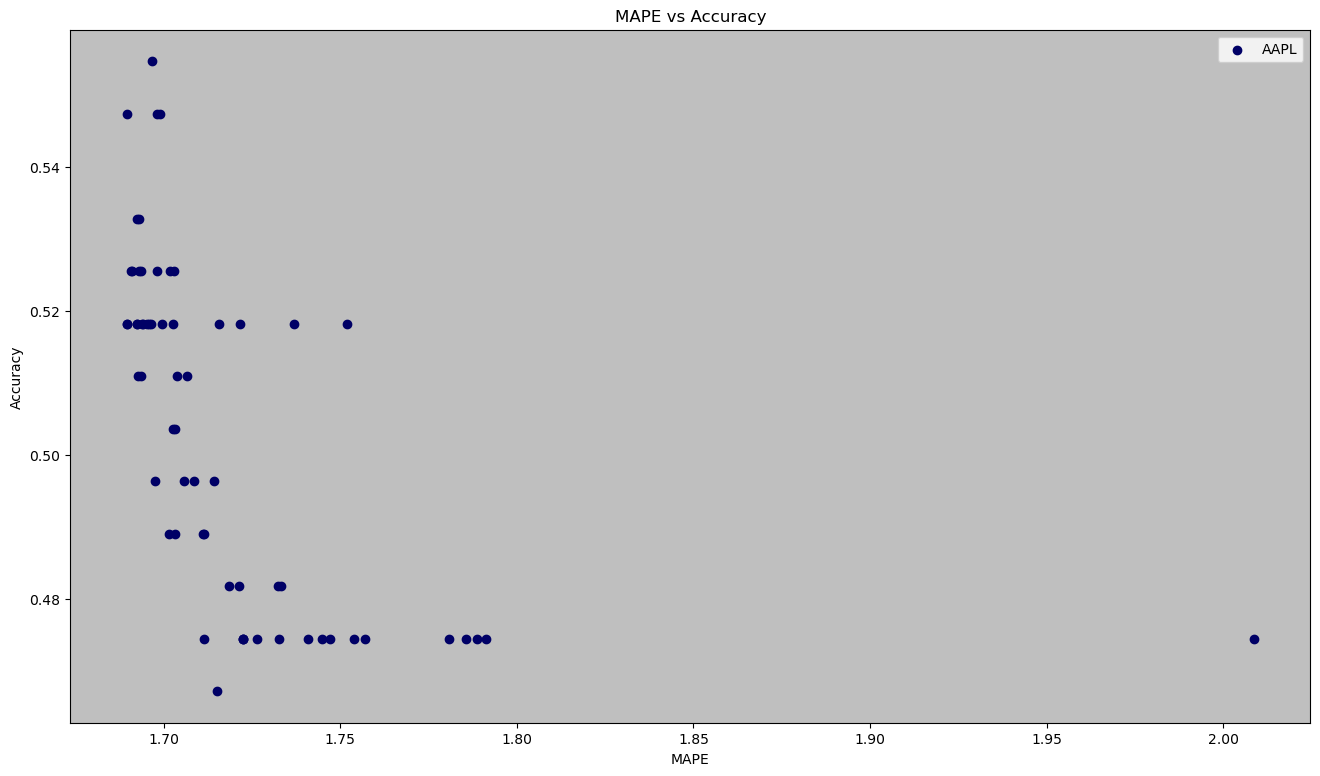

In [60]:
colors = itertools.cycle([(0,0,0.4),(0,0,0.8),(0.6,0,0),(0.8,0,0)])

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()
ax.set_facecolor([.75,.75,.75])
ax.set_title("MAPE vs Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("MAPE")
for i in range(len(results_df_direction)):
    ax.scatter(results_df_mae.loc[results_df_mae.index[i]], results_df_direction.loc[results_df_direction.index[i]], color=next(colors), label=tickers[i])
plt.legend()